# Introduction



---



---



In this notebook, I perform continuation over alpha_hat.


- For each alpha_hat, I do a nonlinear mesh solve, based on the analytical gradient based M (Linear Madden Problem).


- I then do a physical solve on the newly computed mesh so that I can compute the errors in the physical solution on this mesh.

- I record the L2 error of each solve and pick the `best solve' based on the alpha_hat that led to the physical solution with the lowest L2 error.

#### July 2025

# Results and Conclusions


---



---



- Seems like a noisey relationship between alpha_hat and the quality of our solution approximations. This is not good. We need to explore other ways to pick the scaling on the Hessian in the Mesh Density Function.




In [ ]:
# install firedrake

# hide output
%%capture

# try:
#     import firedrake
# except ImportError:
#     !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
#     import firedrake


try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

In [ ]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [ ]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d
from scipy.interpolate import interp1d
import sympy as sp
import scipy as sci

# Setup

In [ ]:
# SETUP
#################################################

# Grid size and epsilon
N = 50
eps = Constant(0.001)
epsilon = 0.001


# Set our parameters for the hessian mesh density
# d = 1
q = Constant(2)
exp_M = q / (1+q)
exp_alpha = (2*(1+q))/q



# Initialize uniform mesh for xi
xi_mesh = UnitIntervalMesh(N)
xi_coord = SpatialCoordinate(xi_mesh)[0]


# Our function spaces
V = FunctionSpace(xi_mesh, "CG", 2)
V_phys = FunctionSpace(xi_mesh, "CG", 4)

# Set initial x(xi) to be uniform grid
xi_func = Function(V)
xi_func.interpolate(xi_coord)
perm_x = np.argsort(xi_func.dat.data[:])


# solver parameters
lu_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}

mesh_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'richardson',
    # 'ksp_richardson_scale': 0.5,
    'pc_type': 'lu',
}


newton_params = {
        'snes_type': 'newtonls',
        'snes_monitor': None,
        'ksp_type': 'preonly',
        'snes_linesearch_type': 'basic',
        'snes_linesearch_monitor': None,
        'snes_linesearch_damping': 0.5,
        'pc_type' : 'lu',
        'snes_rtol': 1e-8,
        'snes_stol': 1e-8,
        'snes_max_it': 100
}

# Create a B Mesh for Comparison

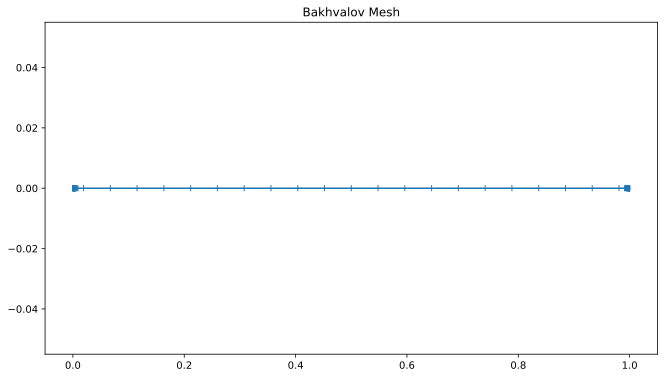

In [ ]:
# Form the 1D B mesh to compare
NB = 2*N
q = 0.4 #roughly 20 points in the layers
sigma = 2.5
b = 1
a = sigma/b
tau = q-a*epsilon
error = 1


while error>1e-14:

  g2 = a*epsilon*(0.5-tau)-(0.5+a*epsilon*np.log(1-tau/q))*(q-tau)
  g2_tau = 1 + a*epsilon*np.log(1-tau/q)
  tau_new =tau-g2/g2_tau
  error = abs(tau-tau_new)
  tau=tau_new


if tau>0:

  phi = -a*epsilon*np.log(1-tau/q)
  phi_tau = a*epsilon/(q-tau)
  x_uni = np.linspace(0, 1, NB+1)
  x_b = np.zeros(NB+1)

  for i in range(1,int(NB/2+1)):
    if x_uni[i]<tau:
      x_b[i] = -a*epsilon*np.log(1-x_uni[i]/q)
    else:
      x_b[i] = -a*epsilon*np.log(1-tau/q)+(x_uni[i]-tau)*phi_tau

  for i in range(int(NB/2+1),NB+1):
    x_b[i] = 1-x_b[NB-i]


else:

  x_b = np.linspace(0, 1, NB+1)


# Plot the result
plt.plot(x_b, [0 for i in range(NB+1)], marker = "|")
plt.title('Bakhvalov Mesh')
plt.show()

# Continuation over alpha_hat, analytica du/dx, nonlinear x solve.

In [ ]:
first_alpha_int = 3
last_alpha_int = -1
first_alpha = 10**first_alpha_int
last_alpha = 10**last_alpha_int
alpha_list = np.logspace(first_alpha_int, last_alpha_int, 500)
alpha_fails = []
alpha_passes = []
L2_errors = []
saved_sols = []

# x and H guesses
######################################

# Define x and H guesses
x_guess = Function(V)
H_guess = Function(V)
# x_guess.interpolate(xi_coord)
x_guess.dat.data[perm_x] = x_b[:]



for alpha_val in alpha_list:

    print()
    print()
    print('For Alpha_Hat = ', alpha_val)
    print('_'*150)
    print()
    print()




    # MESH SOLVE SETUP
    #######################################

    # Lets get our x and H
    x = Function(V)
    vm = TestFunction(V)

    # Guesses
    x.dat.data[:] = x_guess.dat.data[:]


    # Check my guesses (confirm continuation)

    print('Have my guesses updated? (Should match last printed x, H, and u norms)')
    print("-"*50)
    print()
    print('x guess norm =', norm(x_guess))
    print()
    print()


    # ANALYTICAL u''
    ######################################

    # x jacobian
    jacobx = x.dx(0)


    # # Exact u and Hessian
    top = (1 - exp(1 - 1/eps)) * exp(-x/eps) + (exp(1) - exp(-1/eps)) * exp((x - 1)/eps)
    bottom = (eps**2 - 1) * (1 - exp(-2/eps))
    sub = exp(x) / (eps**2 - 1)
    u_f = top / bottom - sub
    # Compute u'
    u_pr = (1/jacobx) * u_f.dx(0)

    # Compute alpha
    alpha_hat = Constant(alpha_val)
    alpha_term_1 = (alpha_hat**2) * assemble(u_f*u_f * jacobx * dx)
    alpha_term_2 = assemble( (abs(u_pr)**(exp_M)) * jacobx * dx ) ** exp_alpha
    alpha = conditional( gt(alpha_term_1, alpha_term_2) , alpha_term_1, alpha_term_2)


    # Mesh Density Function
    M = ( 1 + (1/alpha) * (u_pr**2) ) ** exp_M



    # MESH SOLVE WEAK FORM
    # ######################################

    # v'
    v_pr_term = (vm).dx(0)

    # the lhs of the eqn
    F_m = (M * jacobx * v_pr_term) * dx

    # bc's
    bc0 = DirichletBC(V, Constant(0), 1)
    bc1 = DirichletBC(V, Constant(1), 2)
    bcs = [bc0, bc1]



    # MESH SOLVE
    ###########################################

    # Solve

    try:
        # Solve combined problem

        print("Mesh Solve:")
        print("-"*50)
        print()
        solve( F_m == 0, x , bcs = bcs, solver_parameters = newton_params)

        # Update the guesses
        x_guess.dat.data[:] = x.dat.data[:]


    except Exception as e:

        print('Mesh solve failed due to the following message:')
        print(e)
        print()
        alpha_fails.append(alpha_val)
        continue

    # If we make it here, our alpha_hat worked!
    alpha_passes.append(alpha_val)



    # PHYSICAL SOLVE
    #########################################

    # Test and Trial Functions
    u = TrialFunction(V_phys)
    v = TestFunction(V_phys)

    # Jacobian of x
    Jx = x.dx(0) #dx/dxi


    # Set the bilinear and linear forms of the weak form
    u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
    v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
    a = ((eps**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
    L = ( exp(x) ) * v * Jx * dx #transform dxi to dx


    # Set the BC's
    bcs = [DirichletBC(V_phys, Constant(0), 1), DirichletBC(V_phys, Constant(0), 2)]

    # Solve
    try:
      print()
      print("Physical Solve:")
      print("-"*50)
      print()
      u = Function(V_phys)
      solve( a==L, u, bcs = bcs, solver_parameters = lu_params)
    except Exception as e:
      print('The physical solve failed due to the following message:')
      print(e)
      print()
      break



    # MEASURING ERRORS
    #############################################

    print()
    print('Errors in Approximated u:')
    print("-"*50)
    print()
    # Reset exact solution (I think this is a waste)
    top = (1 - exp(1 - 1/eps))*exp(-x/eps) + (exp(1) - exp(-1/eps))*exp((x-1)/eps)
    bottom = (eps**2 - 1) * ( 1 - exp(-2/eps) )
    sub = exp(x)/(eps**2 - 1)
    u_exact = top/bottom - sub

    # L^2 error
    error_val = (u - u_exact)
    L2_error = norm(error_val * (sqrt(abs(Jx))))
    print("L2 error is", L2_error)


    # Save it
    u_sol = Function(V_phys)
    x_sol = Function(V)
    u_sol.dat.data[:] = u.dat.data[:]
    x_sol.dat.data[:] = x.dat.data[:]

    L2_errors.append(L2_error)
    saved_sols.append([alpha_val, u_sol, x_sol])



    # Plot x and u
    print('The Results:')
    print("-"*50)
    print()
    plt.plot(x.dat.data[perm_x], np.zeros_like(x.dat.data[perm_x]), marker = "|")
    plt.plot(x.dat.data[perm_x], Function(V).interpolate(u).dat.data[perm_x], label = "Approximated u")
    plt.plot(x.dat.data[perm_x], Function(V).interpolate(u_exact).dat.data[perm_x], label = "Exact u")
    plt.title("Final Mesh and Physical Solution")
    plt.xlabel("x mesh")
    plt.ylabel("u")
    plt.legend()
    plt.show()
    plt.close()
    print()
    print()
    print()



    # Check the norms
    print('The Norms:')
    print("-"*50)
    print()
    print('x norm = ', norm(x))
    print()
    print()




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Which alpha_hat's worked?

alpha_passes

[np.float64(1000.0),
 np.float64(981.7117022752193),
 np.float64(963.7578663841089),
 np.float64(946.1323755890769),
 np.float64(928.8292250172499),
 np.float64(911.8425196146571),
 np.float64(895.1664721378302),
 np.float64(878.795401182132),
 np.float64(862.723729246145),
 np.float64(846.9459808314585),
 np.float64(831.4567805772064),
 np.float64(816.2508514287229),
 np.float64(801.3230128396887),
 np.float64(786.6681790071582),
 np.float64(772.2813571388642),
 np.float64(758.157645752211),
 np.float64(744.2922330043758),
 np.float64(730.68039505295),
 np.float64(717.3174944465612),
 np.float64(704.1989785449289),
 np.float64(691.3203779678128),
 np.float64(678.6773050723295),
 np.float64(666.265452458115),
 np.float64(654.0805914998252),
 np.float64(642.1185709064758),
 np.float64(630.3753153071282),
 np.float64(618.8468238624383),
 np.float64(607.5291689016077),
 np.float64(596.4184945842466),
 np.float64(585.5110155867244),
 np.float64(574.8030158125357),
 np.float64(564.290847126

In [ ]:
# Which alpha_hat's failed?

alpha_fails

[]

# Plot L2 Error vs. Alpha Hat


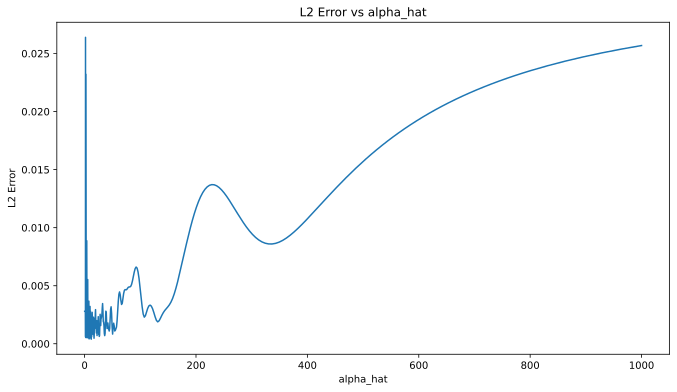

In [ ]:
plt.plot(alpha_passes, L2_errors)
plt.xlabel('alpha_hat')
plt.ylabel('L2 Error')
plt.title('L2 Error vs alpha_hat')
plt.show()

# Show the Best Solution

In [ ]:
# For fun lets find these mins

# Find index of min value in my L2 and H1 lists
min_L2 = min(L2_errors)
index_min_L2 = L2_errors.index(min_L2)

# Pull the corresponding alpha hat value
alpha_min_L2 = alpha_passes[index_min_L2]

print("Alpha value for min L2 error is", alpha_min_L2)


Alpha value for min L2 error is 11.916598430985594


In [ ]:
print('The best solution is for alpha_tilda = ', saved_sols[index_min_L2][0])
best_sol = saved_sols[index_min_L2][1]
best_sol_x = saved_sols[index_min_L2][2]

The best solution is for alpha_tilda =  11.916598430985594


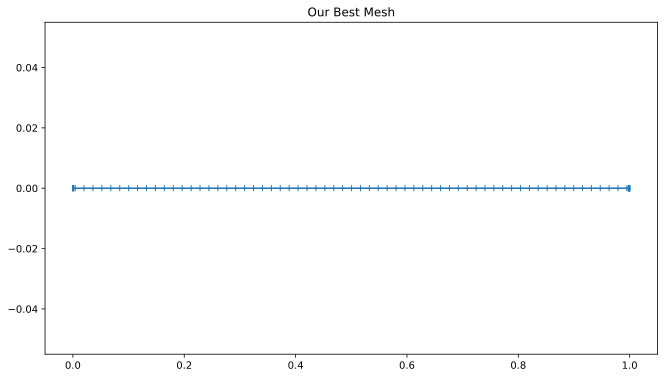

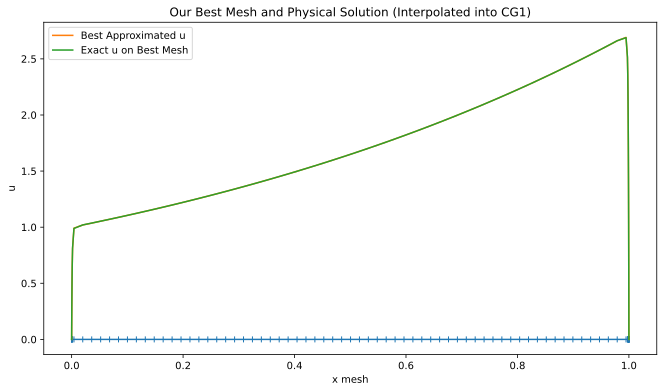

In [ ]:
# Plot the best solution



# Reset exact solution (I think this is a waste)
top = (1 - exp(1 - 1/eps))*exp(-best_sol_x/eps) + (exp(1) - exp(-1/eps))*exp((best_sol_x-1)/eps)
bottom = (eps**2 - 1) * ( 1 - exp(-2/eps) )
sub = exp(best_sol_x)/(eps**2 - 1)
u_exact_best = top/bottom - sub





# Plot
plt.plot(best_sol_x.dat.data[perm_x], np.zeros_like(x.dat.data[perm_x]), marker = "|")
plt.title("Our Best Mesh")
plt.show()
print()
print()

plt.plot(best_sol_x.dat.data[perm_x], np.zeros_like(x.dat.data[perm_x]), marker = "|")
plt.plot(best_sol_x.dat.data[perm_x], Function(V).interpolate(best_sol).dat.data[perm_x], label = "Best Approximated u")
plt.plot(best_sol_x.dat.data[perm_x], Function(V).interpolate(u_exact_best).dat.data[perm_x], label = "Exact u on Best Mesh")
plt.title("Our Best Mesh and Physical Solution (Interpolated into CG1)")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()
print()
print()